# In Class Examples

In this first Notebook, I will follow along the examples provided in class to get a better understanding of where to focus my reconstruction part. 

## Table of Contents

1. [Data Gathering](#data-gathering)
3. [Abstraction](#abstraction)
2. [Evolution Analysis](#evolution-analysis)

## 1. Data Gathering

In [48]:
# Necessary installs
import sys
sys.version
!{sys.executable} -m pip install gitpython
!{sys.executable} -m pip install pyvis

In [49]:
# Folder to store the zeeguu repository
CODE_ROOT_FOLDER = "zeeguu_project/"

In [50]:
from git import Repo
import os

# Clone the repository to the parent directory
if not os.path.exists(CODE_ROOT_FOLDER):
  Repo.clone_from("https://github.com/zeeguu/api", CODE_ROOT_FOLDER)

In [51]:
# Avoid `zeeguu_project` prefix for every import
def file_path(file_name):
    return CODE_ROOT_FOLDER + file_name

assert (file_path("zeeguu/core/model/user.py") == "zeeguu_project/zeeguu/core/model/user.py")

In [52]:
# Extracting module names from the file paths
def module_name_from_file_path(full_path):
    file_name = full_path[len(CODE_ROOT_FOLDER):]
    file_name = file_name.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

assert 'zeeguu.core.model.user' == module_name_from_file_path(file_path('zeeguu/core/model/user.py'))

In [53]:
# Extracting imports using regular expressions
import re

def import_from_line(line):
    try:
        # ^ - start of the line
        # (?:from|import) - non-capturing group for either 'from' or 'import'
        # (\S+) - capturing group for one or more non-whitespace characters
        y = re.search("^(?:from|import) (\S+)", line)
        if y:
            return y.group(1)
    except:
        pass
    return None

# Extract all imports from a file
def imports_from_file(file):
    all_imports = []

    lines = [line for line in open(file)]

    for line in lines:
        imp = import_from_line(line)

        if imp:
            all_imports.append(imp)

    return all_imports

imports_from_file(file_path('zeeguu/core/model/user.py'))

['datetime',
 'json',
 'random',
 're',
 'sqlalchemy.orm',
 'zeeguu.core',
 'sqlalchemy',
 'sqlalchemy.orm',
 'sqlalchemy.orm.exc',
 'zeeguu.core.language.difficulty_estimator_factory',
 'zeeguu.core.model',
 'zeeguu.core.model.learning_cycle',
 'zeeguu.logging',
 'zeeguu.core.util',
 'zeeguu.core.model',
 'zeeguu.logging']

In [54]:
# Extract dependencies between all files
import pathlib
from pathlib import Path
import networkx as nx

def dependencies_graph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.Graph()

    for file in files:
        file_path = str(file)

        module_name = module_name_from_file_path(file_path)

        if module_name not in G.nodes:
            G.add_node(module_name)

        for each in imports_from_file(file_path):
            G.add_edge(module_name, each)

    return G

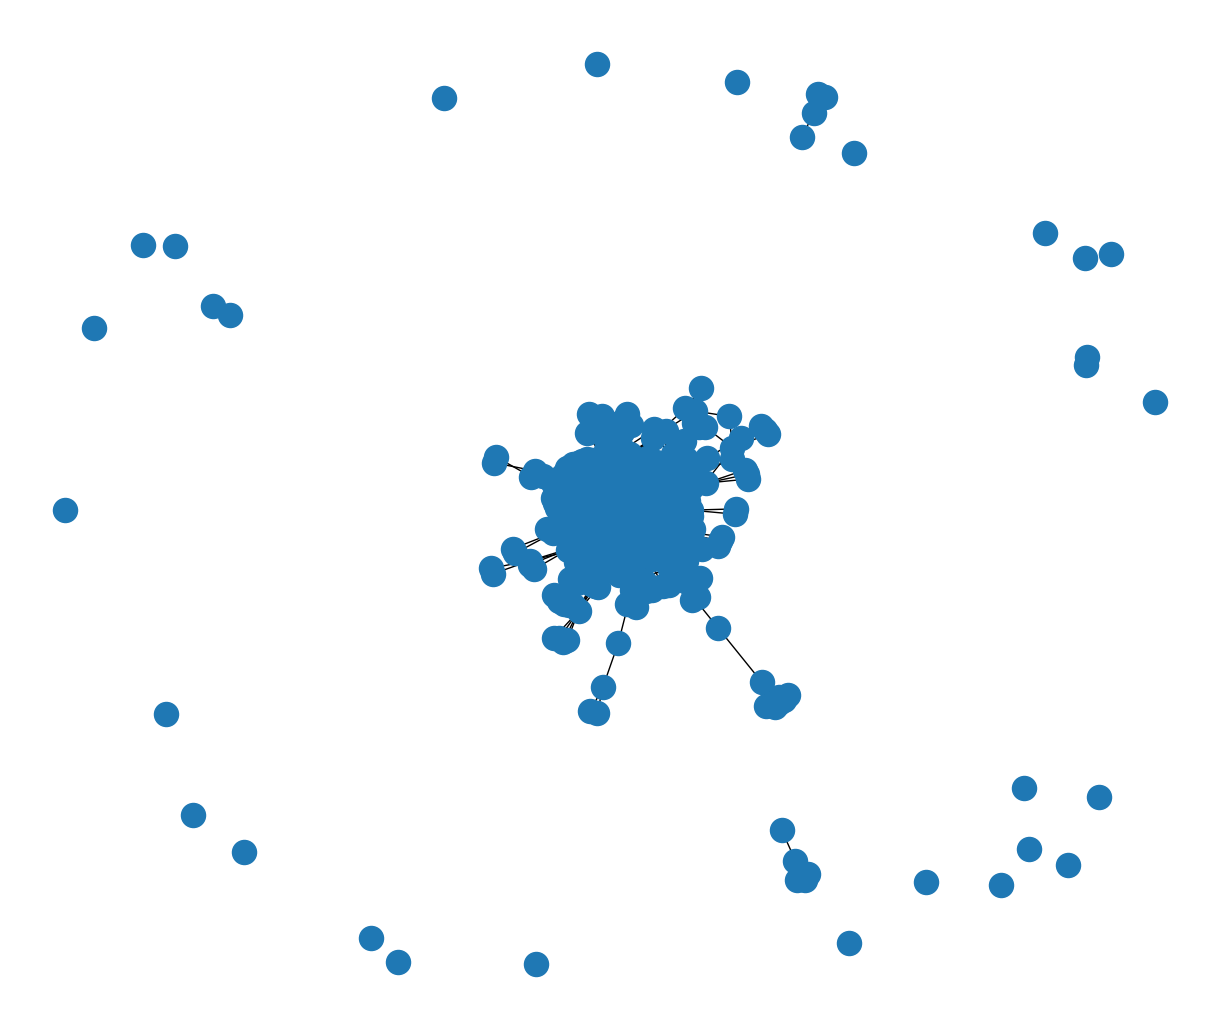

In [55]:
# Draw the graph
import matplotlib.pyplot as plt

def draw_graph(G, size, **args):
    plt.figure(figsize=size)
    nx.draw(G, **args)
    plt.show()

G = dependencies_graph(CODE_ROOT_FOLDER)
draw_graph(G, (12,10), with_labels=False)

## 2. Abstraction

In [56]:
# Removing tests and only considering Zeeguu modules
def relevant_module(module_name):
  if "test" in module_name:
    return False

  if module_name.startswith("zeeguu"):
    return True

  return False

In [57]:
# However, if we think a bit more about it, we realize that a dependency graph
# is a directed graph (e.g. module A depends on m)
# with any kinds of graph either directed (nx.DiGraph) or
# non-directed (nx.Graph)
def dependencies_digraph(code_root_folder):
    files = Path(code_root_folder).rglob("*.py")

    G = nx.DiGraph()

    for file in files:
        file_path = str(file)

        source_module = module_name_from_file_path(file_path)
        if not relevant_module(source_module):
          continue

        if source_module not in G.nodes:
            G.add_node(source_module)

        for target_module in imports_from_file(file_path):

            if relevant_module(target_module):
              G.add_edge(source_module, target_module)

    return G

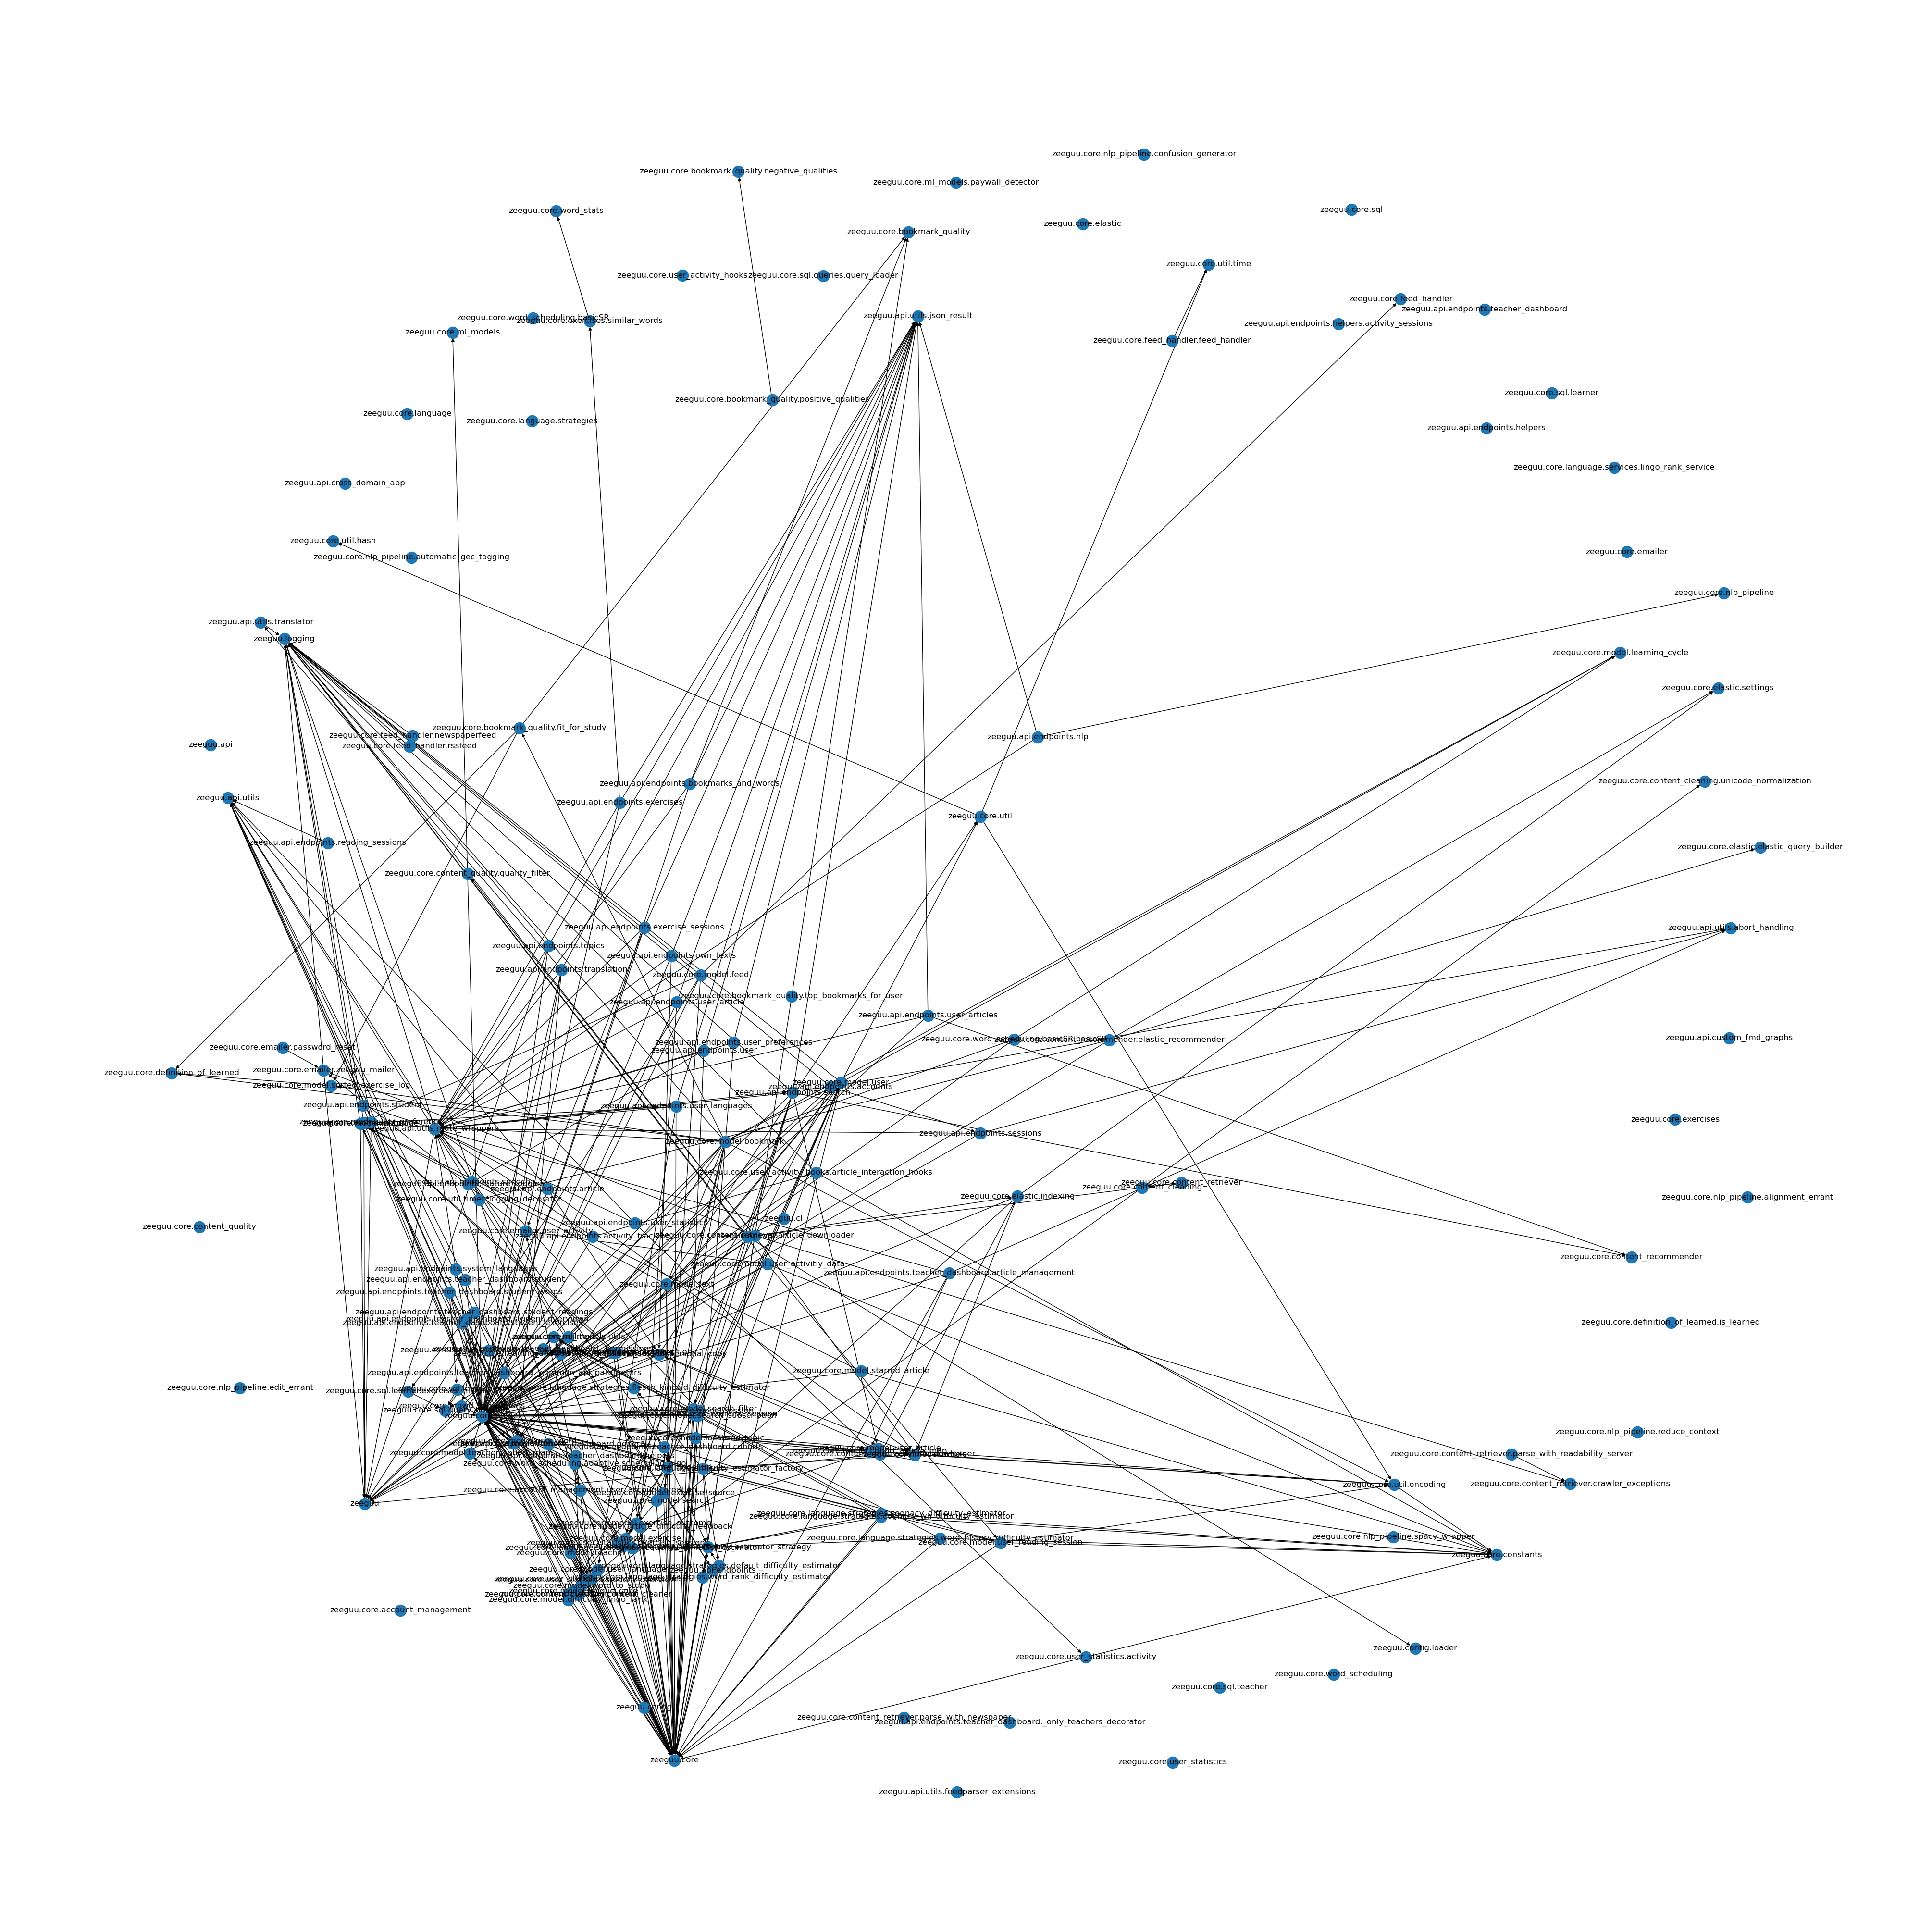

In [58]:
# Looking at the directed graph
DG = dependencies_digraph(CODE_ROOT_FOLDER)
draw_graph(DG, (40,40), with_labels=True)

In [59]:
# Abstracting with hierarchical levels
def top_level_package(module_name, depth=1):
    components = module_name.split(".")
    return ".".join(components[:depth])

assert (top_level_package("zeeguu.core.model.util") == "zeeguu")
assert (top_level_package("zeeguu.core.model.util", 2) == "zeeguu.core")

In [60]:
def abstracted_to_top_level(G, depth=1):
    aG = nx.DiGraph()
    for each in G.edges():
        src = top_level_package(each[0], depth)
        dst = top_level_package(each[1], depth)

        if src != dst:
          aG.add_edge(src, dst)

    return aG

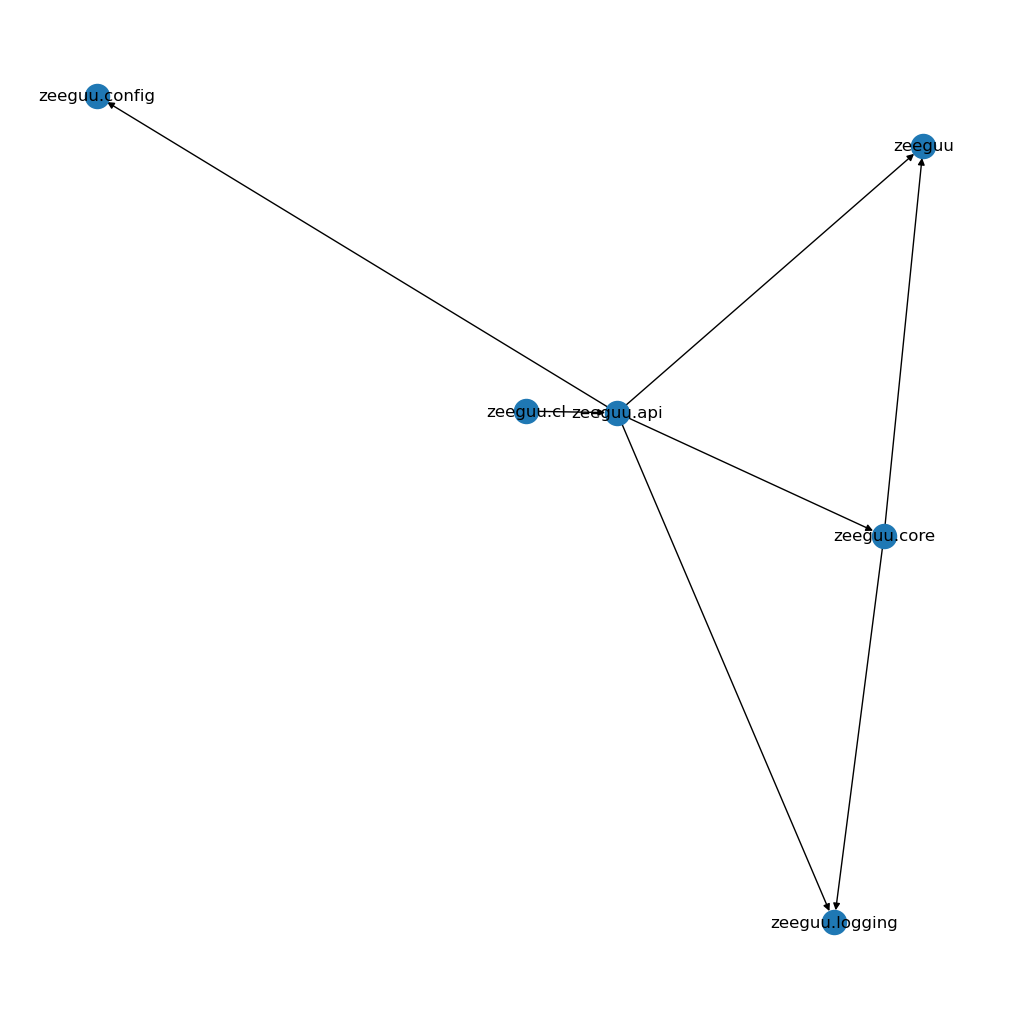

In [61]:
ADG = abstracted_to_top_level(DG, 2)

plt.figure(figsize=(10,10))
nx.draw(ADG, with_labels=True)
plt.show()

## 3. Evolution Analysis

In [62]:
!{sys.executable} -m pip install pydriller

In [63]:
from pydriller import Repository
REPO_DIR = 'https://github.com/zeeguu/api'

In [64]:
# Change directory to the root folder in the repository
%cd zeeguu_project/

/Users/simonskodt/Library/Mobile Documents/com~apple~CloudDocs/8_semester/SOARC_Software-Architecture/Individual-project/architectural-reconstruction/reconstruction/zeeguu_project/zeeguu_project


In [65]:
# Get all commits and print out the commit details
all_commits = list(Repository(REPO_DIR).traverse_commits())

def print_out_commit_details(commits):
  for commit in commits:
      print(commit)
      for each in commit.modified_files:
          print(f"{commit.author.name} {each.change_type} {each.filename}\n -{each.old_path}\n -{each.new_path}")

print_out_commit_details(all_commits[0:1])

Mircea Lungu ModificationType.ADD LICENSE
 -None
 -LICENSE
Mircea Lungu ModificationType.ADD README.md
 -None
 -README.md
Mircea Lungu ModificationType.ADD s
 -None
 -s
Mircea Lungu ModificationType.ADD setup.py
 -None
 -setup.py
Mircea Lungu ModificationType.ADD zeeguu_api.wsgi
 -None
 -zeeguu_api.wsgi
Mircea Lungu ModificationType.ADD __init__.py
 -None
 -zeeguu_api/__init__.py
Mircea Lungu ModificationType.ADD __main__.py
 -None
 -zeeguu_api/__main__.py
Mircea Lungu ModificationType.ADD __init__.py
 -None
 -zeeguu_api/api/__init__.py
Mircea Lungu ModificationType.ADD download_content_from_url.py
 -None
 -zeeguu_api/api/download_content_from_url.py
Mircea Lungu ModificationType.ADD exercises.py
 -None
 -zeeguu_api/api/exercises.py
Mircea Lungu ModificationType.ADD feeds.py
 -None
 -zeeguu_api/api/feeds.py
Mircea Lungu ModificationType.ADD sessions.py
 -None
 -zeeguu_api/api/sessions.py
Mircea Lungu ModificationType.ADD smartwatch.py
 -None
 -zeeguu_api/api/smartwatch.py
Mircea Lungu 

In [66]:
# This code snippet counts the number of commits for each modified file in a list of commits.
# It uses a defaultdict to store the commit counts and iterates through each commit and its modified files.
from collections import defaultdict

commit_counts = defaultdict(int)

for commit in all_commits:
    for each in commit.modified_files:
        try:
            commit_counts [each.new_path] += 1
        except:
            pass

# sort by number of commits in decreasing order
sorted(commit_counts.items(), key=lambda x: x[1], reverse=True)[:42]

# discussion: What is ("None", 103) ?

[(None, 175),
 ('zeeguu_api/api/dashboard.py', 80),
 ('zeeguu_api/api/translate_and_bookmark.py', 78),
 ('zeeguu_api/api/teacher_dashboard.py', 76),
 ('requirements.txt', 52),
 ('zeeguu_api/api/feeds.py', 51),
 ('zeeguu_api/app.py', 51),
 ('zeeguu/core/emailer/zeeguu_mailer.py', 48),
 ('zeeguu_api/api/__init__.py', 44),
 ('zeeguu/core/content_retriever/article_downloader.py', 43),
 ('README.md', 41),
 ('zeeguu/core/model/article.py', 41),
 ('.travis.yml', 34),
 ('setup.py', 33),
 ('tools/update_article_content.py', 30),
 ('zeeguu_api/api/exercises.py', 29),
 ('zeeguu/core/model/user.py', 29),
 ('zeeguu/core/emailer/user_activity.py', 28),
 ('zeeguu_api/api/sessions.py', 27),
 ('zeeguu/core/model/__init__.py', 27),
 ('zeeguu_api/user_activity_hooks/article_interaction_hooks.py', 25),
 ('zeeguu_api.wsgi', 24),
 ('zeeguu/core/content_recommender/elastic_recommender.py', 24),
 ('zeeguu/core/model/language.py', 24),
 ('zeeguu_api/api/user_articles.py', 23),
 ('zeeguu_api/api/bookmarks_and_w

In [67]:
# Iterate over the collection of commits and their modified files, keeping track 
# of the number of modifications for each file. Sort the file modification 
# counts in descending order.
from pydriller import ModificationType

commit_counts = {}

for commit in all_commits:
    for modification in commit.modified_files:

        new_path = modification.new_path
        old_path = modification.old_path

        try:

            if modification.change_type == ModificationType.RENAME:
                commit_counts[new_path]=commit_counts.get(old_path,0)+1
                commit_counts.pop(old_path)

            elif modification.change_type == ModificationType.DELETE:
                commit_counts.pop(old_path, '')

            elif modification.change_type == ModificationType.ADD:
                commit_counts[new_path] = 1

            else: # modification to existing file
                    commit_counts [old_path] += 1
        except Exception as e:
            print("something went wrong with: " + str(modification))
            pass

sorted(commit_counts.items(), key=lambda x:x[1], reverse=True)

[('zeeguu/api/endpoints/translation.py', 95),
 ('zeeguu/api/app.py', 71),
 ('zeeguu/api/endpoints/__init__.py', 54),
 ('zeeguu/core/model/article.py', 51),
 ('zeeguu/core/emailer/zeeguu_mailer.py', 49),
 ('zeeguu/api/endpoints/exercises.py', 49),
 ('requirements.txt', 47),
 ('zeeguu/core/content_retriever/article_downloader.py', 45),
 ('README.md', 41),
 ('zeeguu/core/model/user.py', 34),
 ('zeeguu/api/endpoints/feature_toggles.py', 34),
 ('setup.py', 33),
 ('zeeguu/api/endpoints/user.py', 33),
 ('zeeguu/api/endpoints/user_articles.py', 31),
 ('zeeguu/core/model/__init__.py', 30),
 ('zeeguu/api/endpoints/accounts.py', 30),
 ('zeeguu/api/endpoints/sessions.py', 30),
 ('tools/update_article_content.py', 30),
 ('zeeguu/core/emailer/user_activity.py', 29),
 ('zeeguu/core/model/bookmark.py', 29),
 ('zeeguu/api/endpoints/bookmarks_and_words.py', 29),
 ('zeeguu/api/endpoints/speech.py', 29),
 ('zeeguu/api/endpoints/topics.py', 27),
 ('zeeguu/core/content_recommender/elastic_recommender.py', 2

In [68]:
def module_name_from_rel_path(full_path):
    # e.g. ../core/model/user.py -> zeeguu.core.model.user

    file_name = full_path.replace("/__init__.py","")
    file_name = file_name.replace("/",".")
    file_name = file_name.replace(".py","")
    return file_name

assert ("tools.migrations.teacher_dashboard_migration_1.upgrade" == module_name_from_rel_path("tools/migrations/teacher_dashboard_migration_1/upgrade.py"))

assert ("zeeguu.api") == module_name_from_rel_path("zeeguu/api/__init__.py")

In [69]:
package_activity = defaultdict(int)

for path, count in commit_counts.items():
    if ".py" in str(path):
        l2_module = top_level_package(module_name_from_rel_path(path), 2)
        package_activity[l2_module] += count

sorted_sizes = sorted(package_activity.items(), key=lambda x: x[1], reverse=True)

In [70]:
sizes = []

for n in ADG.nodes():
  sizes.append(package_activity[n])

print(sizes)

[1171, 1, 2, 925, 10, 2]


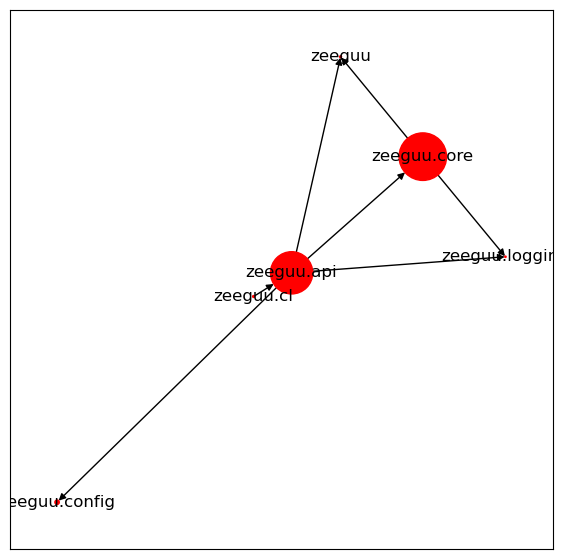

In [71]:
plt.figure(figsize=(7,7))
nx.draw_networkx(ADG, with_labels=True, node_size = sizes, node_color='r')
plt.show()